# Assessment of benthic fluxes

Author: Mathurin Choblet (mchoblet@uliege.be)

Date: 31.01.2025

The period 1990 - 1999 is chosen because this is when most datapoints where sampled (from Friedl and Friedrich studies, which contain more fluxes than only oxygen as in Lichtschlag and Lenstra papers)

In [2]:
import numpy as np
import xarray as xr
import glob
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.dates as md
import seaborn as sns #for the colorpalette

import cartopy.crs as ccrs
projection=ccrs.PlateCarree()
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import BoundaryNorm,ListedColormap
from matplotlib.colorbar import ColorbarBase

import pandas as pd

from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.lines import Line2D


#Helpers
def convert_xy(ds,domain_path):    
    """  
    Convert latitudes and longitudes from nested to normal + perform land sea masking
    Input:
        ds: xarray dataset (any shape)
        domain_path: path to domain file
    Output:
        ds: Dataset with simple 1D coordinates for latitudes and longitudes.
    """ 
    
    domain=xr.open_dataset(domain_path)
    lon=domain['nav_lon'][0,:].values
    lat=domain['nav_lat'][:,0].values
    
    ds=ds.rename({'y':'lat','x':'lon'})
    #assignment of new coordinates
    ds['lat']=('lat',lat)
    ds['lon']=('lon',lon)
    ds=ds.drop(('nav_lat','nav_lon'))

    #only keep at least 2 dimension variables
    ds = ds.drop_vars([var for var in ds.data_vars if ds[var].ndim < 2])
    
    #land sea masking, for this, we use top_level variable (strictly speaking, the follwing only does the masking for the first layer)
    lsmask=domain['top_level'].squeeze().rename({'y':'lat','x':'lon'})
    lsmask['lat']=lat
    lsmask['lon']=lon

    ds=xr.where(lsmask==1,ds,np.nan)
    return ds

def load_domain(
              domain_path=None, #domain either a filepath, or an xarray dataarray. latter needed when reading in data (used for masking)
              y='nav_lat', #name of y-dimension
              x='nav_lon', #name of x-dimension
              depth_var='deptht', #name of depth variable. eventually rename that later to match your model data (depends if data on U_, V_, W_ grid)
              top_level='top_level',
             ):
    """
    Preprocessing wrapper for domain file
    
    1. Load 
    2. Convert Lat/Lon
    3. Land Sea Masking

    """
    
    if domain_path==None:
        print('Nothing loaded. Please indicate File path to domain file of model run')
    else:
        global domain #such that it can be accessed for sure
        domain=xr.open_dataset(domain_path).squeeze().rename({'nav_lev':depth_var})

        latitudes = domain[y].values
        longitudes = domain[x].values
        # Flatten latitudes and longitudes. get rid of -1 that are sometimes in the model data
        flat_latitudes = np.setdiff1d(np.unique(latitudes.flatten()), [-1])
        flat_longitudes = np.setdiff1d(np.unique(longitudes.flatten()), [-1])
        domain[y] = ('y', flat_latitudes)
        domain[x] = ('x', flat_longitudes)
        domain = domain.rename({y: 'lat', x: 'lon'})
        domain = domain.rename({'x': 'lon', 'y': 'lat'}).set_index({'lat': 'lat', 'lon': 'lon'})
        global ls_mask
        ls_mask=domain[top_level]
    return domain

def create_depth_mask(domain, d0=0, d1=100, depth_var='deptht'):
    """
    Create a mask for depths between d0 and d1 based on the domain file.
    
    Parameters:
    domain (xarray.Dataset): The domain dataset containing depth information
    d0 (float): Minimum depth (inclusive)
    d1 (float): Maximum depth (inclusive)
    depth_var (str): Name of the depth variable in the domain file
    
    Returns:
    xarray.DataArray: A boolean mask where True indicates depths within [d0, d1]
    """
    if 'bottom_level' in domain:
        # If bottom_level is available, use it to get the bottom depth
        bottom_depth = domain[depth_var].values[domain['bottom_level'].values]
    elif depth_var in domain:
        # If depth_var is directly available in the domain
        bottom_depth = domain[depth_var]
    else:
        raise ValueError(f"Cannot find depth information in the domain file using {depth_var}")
    
    # Create the mask
    mask = (bottom_depth >= d0) & (bottom_depth <= d1)
    
    # Ensure the mask has proper coordinates
    mask = xr.DataArray(mask, coords={'lat': domain['lat'], 'lon': domain['lon']}, 
                        dims=['lat', 'lon'])
    mask=xr.where(domain['top_level'],mask,np.nan)
    return mask

   
def mask_latlon(data,lats,lons,ls_mask):
    """
    Mask data according to latitude and longitude bounds. The purpose are regional mean computations.
    For plots focussing on a specific region just cut the data to a specific region (e.g. the Black Sea North Western Shelf
    .sel(lat=slice(42.2,47),lon=slice(27.5,34.1))

    Input:
        data: either regular 2D,3D,4D data, or simple 2d mask
        lat=[lat1,lat2] latitudinal bounds of region to keep 
        lon=[lon1,lon2] longitudinal bounds of region to keep
    Output:
        mask (or masked data)
    
    """
    data=data.where(((data.lat>=lats[0]) & (data.lat<=lats[1]) & (data.lon>=lons[0]) & (data.lon<=lons[1])))
    data=xr.where(ls_mask,data,np.nan)
    return data


In [3]:
#reduce dataset to shelf area
sel=lambda ds :ds.sel(lat=slice(44,47),lon=slice(28.5,33.8))

domain_path='/gpfs/scratch/acad/bsmfc/river_forcings/data/domain_hr.nc'
domain_hr=load_domain(domain_path)
bot=domain_hr['bottom_level'].squeeze().drop('time_counter')

## Load benthic data from model run
* Model run corresponds to CMEMS Black Sea biogeochemical reanalysis (assimilating chlorophyll from 1997 on)
* 14mb per day -> 10 years of benthic data 365*10*14/1024=49gigabytes

In [4]:
#files with missing time axis that need to be filled
datatype='btrc_T'
missing = [ 
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/1999/BS_1d_19990217_19990217_{datatype}_19990217-19990217.nc', #will be filled with forward filling
]

#loading takes about ~10 minutes
paths=sorted(glob.glob('/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/*/BS_1d*_btrc_T*199*'))
benthic_90s=xr.open_mfdataset([p for p in paths if p not in missing],preprocess=lambda ds: ds[['botfluxNOS','botfluxNHS','botfluxDOX','botfluxPHO','botfluxSIO']]).load()
benthic_90s_fill=benthic_90s.resample(time_counter='D').mean()
benthic_90s_fill=convert_xy(benthic_90s_fill,'/gpfs/scratch/acad/bsmfc/river_forcings/data/domain_hr.nc')

## Load insitu data CSV Files

In [6]:
#data copied directly from papers (Friedrich 2002 has the more extensive list)
#Friedl 1998: doi:10.1006/ecss.2000.0653, 
#Friedrich 2002: https://doi.org/10.1006/ecss.2000.0653

friedl = pd.read_csv('/gpfs/home/acad/ulg-mast/mchoblet/benthic_github/friedl_friedrich.csv', sep=',', skiprows=4)
df = friedl

# Function to find the matching station code
def find_station_code(location):
    for code in locations.keys():
        if code in location:
            return code
    return None

# Define nutrients and seasons
nutrients = ['O₂', 'NH₄⁺', 'NO₃⁻', 'NO₂⁻', 'HPO₄²⁻', 'Si(OH)₄']
seasons = ['spring 1997', 'summer 1995']

# Create a dictionary to store datasets for each location
datasets = {}
for _, row in df.iterrows():
    station = row['Location']
    if station not in datasets:
        # Create a new dataset for this station
        data_vars = {}
        for nutrient in nutrients:
            if nutrient == 'O₂':
                # Special case for O₂: assign it to summer_val
                spring_val = np.nan
                summer_val = row.get(nutrient, np.nan)
            else:
                spring_val = row.get(f"{nutrient} A", np.nan)
                summer_val = row.get(f"{nutrient} B", np.nan)
            data_vars[nutrient] = (['season'], [spring_val, summer_val])
        
        datasets[station] = xr.Dataset(
            data_vars=data_vars,
            coords={'season': seasons,
                    'lat': row['Latitude'],
                    'lon': row['Longitude']}
        )
        
        # Add attributes
        datasets[station].attrs['description'] = f'Benthic fluxes at {row["Location"]}'
        datasets[station].attrs['units'] = 'mmol m⁻² day⁻¹'
        datasets[station] = datasets[station].rename({
            'NH₄⁺': 'botfluxNHS',
            'O₂': 'botfluxDOX',
            'NO₃⁻': 'botfluxNOS',
            'HPO₄²⁻': 'botfluxPHO',
            'Si(OH)₄': 'botfluxSIO'
        })

friedl_da = datasets

In [7]:
#oxygen flux data from wytze lenstra's papers:  
#https://doi.org/10.1016/j.chemgeo.2018.10.024 (in particular table 3, where I copied and pasted data from)
#https://doi.org/10.1016/j.gca.2020.01.031

#ATTENTION: TAKING NEGATIVE VALUES (FLUXES FROM WATER COLUMN TO SEDIMENTS)

df_lenstra=pd.read_csv('/gpfs/home/acad/ulg-mast/mchoblet/benthic_github/lenstra_published_data.csv',sep=',',skiprows=3)
df=df_lenstra

# Rename columns to match the previous CSV file
column_mapping = {
    'O2': 'O₂',
}
df = df.rename(columns=column_mapping)
df = df.groupby('Station').mean(numeric_only=True)

# List of nutrients
nutrients = ['O₂']

# Create datasets for each station
station_datasets = {}
for station in df.index:
    station_data = df[df.index==station]
    
    # Create a dictionary of DataArrays for each nutrient
    data_vars = {}
    for nutrient in nutrients:
        data_vars[nutrient] = xr.DataArray(
            data=-station_data[nutrient],
            attrs={'units': 'mmol m⁻² day⁻¹'}
        )
    # Create the Dataset
    station_datasets[station] = xr.Dataset(
        data_vars=data_vars,
        coords={
            'lat': station_data['Latitude'],
            'lon': station_data['Longitude'],
            #'depth': station_data['Depth']
        },
        attrs={
            'description': f'Benthic fluxes for Station {station}',
            'latitude_units': 'degrees_north',
            'longitude_units': 'degrees_east',
            #'depth_units': 'meters'
        }
    )
    station_datasets[station]=station_datasets[station].rename({'O₂':'botfluxDOX'})
lenstra_da=station_datasets

In [8]:
#Lichtschlag 2015 paper data: doi:10.5194/bg-12-5075-2015
#table 2: total oxygen uptake
lichtschlag_data = [
        (44.82433333, 33.16116667, -14.9),
        (44.64883333, 32.99966667, -7.3),
        (44.62633333, 32.91616667, -1.6),
    ]


# Plot depth masks and in-situ locations

In [9]:
masks=[mask_latlon(create_depth_mask(domain, d0=d1, d1=d2, depth_var='deptht'),lats=[43,47],lons=[27.5,34],ls_mask=domain['top_level']) for (d1,d2) in [(0,40),(41,80),(81,200)]]

/gpfs/home/acad/ulg-mast/mchoblet/.conda/envs/env/lib/python3.11/site-packages/shapely/predicates.py:671: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)


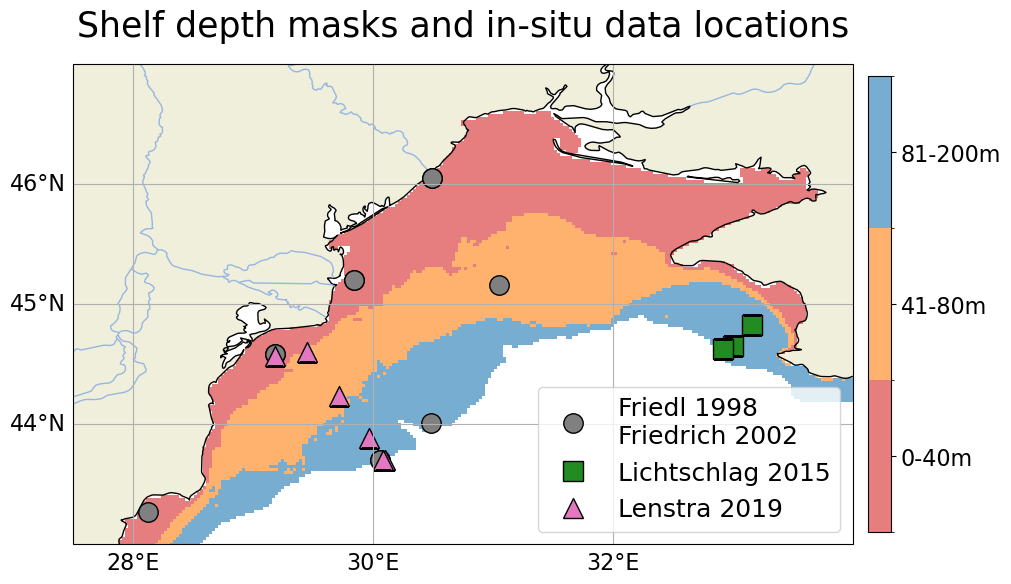

In [10]:
def plot_black_sea(masks=masks, show_locations=True):
    TITLESIZE = 25
    TICKLABELSIZE = 16
    LEGENDSIZE = 18
    
    # Create figure with constrained layout
    fig = plt.figure(figsize=(10, 7), constrained_layout=True)
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    
    # Your existing mask creation code
    bu = xr.where(masks[0]==1, 1, np.nan)
    bubu = xr.where(masks[1]==1, 2, bu)
    bub = xr.where(masks[2]==1, 3, bubu)
    
    # Map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.LAND)
    
    # Set extent
    ax.set_extent([27.5, 34, 43, 47], crs=ccrs.PlateCarree())
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.xlocator = mticker.FixedLocator([28, 30, 32, 34])
    gl.ylocator = mticker.FixedLocator([44, 45, 46])
    gl.xlabel_style = {'size': TICKLABELSIZE}
    gl.ylabel_style = {'size': TICKLABELSIZE}
    gl.top_labels = False
    gl.right_labels = False
    
    # Create custom colormap
    colors = ['tab:red', 'tab:orange', 'tab:blue']
    cmap = ListedColormap(colors)
    norm = BoundaryNorm([0.5, 1.5, 2.5, 3.5], cmap.N)
    
    """
    cmap = plt.get_cmap('viridis', 3)
    norm = BoundaryNorm([0.5, 1.5, 2.5, 3.5], cmap.N)
    """
    
    # Plot the depth masks with colorbar
    im = xr.where(ls_mask, bub, np.nan).plot(
        ax=ax,
        cmap=cmap,
        norm=norm,
        alpha=0.6,
        add_colorbar=True,
        cbar_kwargs={
            'label': None,
            'ticks': [1, 2, 3],
            'boundaries': [0.5, 1.5, 2.5, 3.5],
            'spacing': 'proportional',
            'orientation': 'vertical',
            'shrink':0.66,
            'pad': 0.02,
        }
    )
    
    # Adjust colorbar labels after creation
    im.colorbar.ax.set_yticklabels(['0-40m', '41-80m', '81-200m'], fontsize=TICKLABELSIZE)
    
    if show_locations:
        # Plot data points
        ax.plot(friedl['Longitude'], friedl['Latitude'], 'o', 
                markersize=14, transform=ccrs.PlateCarree(),
                label='Friedl 1998 \nFriedrich 2002',
                markeredgecolor='black', color='gray')
        
        ax.plot([lat for lon, lat, _ in lichtschlag_data],
                [lon for lon, lat, _ in lichtschlag_data], 's',
                markersize=14, transform=ccrs.PlateCarree(),
                label='Lichtschlag 2015',
                markeredgecolor='black', color='forestgreen')
        
        ax.plot(df_lenstra['Longitude'], df_lenstra['Latitude'], '^',
                markersize=14, transform=ccrs.PlateCarree(),
                label='Lenstra 2019',
                markeredgecolor='black', color='tab:pink')
        

        
        ax.legend(loc='lower right', frameon=True,
                 framealpha=0.8, fontsize=LEGENDSIZE)
    
    # Set title
    title = "Shelf depth masks and in-situ data locations" if show_locations else "Shelf depth masks"
    ax.set_title(title, fontsize=TITLESIZE, pad=20)
    
    return fig

fig1=plot_black_sea(show_locations=True) 

In [151]:
fig1.savefig('locations.pdf',format='pdf',bbox_inches='tight')
fig1.savefig('locations.png',format='png',bbox_inches='tight')

# Annual cycle plot

* Note: A single datapoint for the oxygen fluxes in the bay of warna has been removed (positive outlier, meaning flux from sediments into the water), the plot limits would explode

In [11]:
months = MonthLocator(bymonth=[1, 4, 7, 10])  # Locator for January, April, July, October
month_fmt = DateFormatter('%b')  # Formatter to display short month names

def average_yearly_evolution(dataarray):
    dataarray.coords['day_of_year'] = dataarray['time_counter'].dt.dayofyear
    return dataarray.groupby('day_of_year').mean()

# Function to add connection patches
def add_connection_patch(ax1, ax2, y1, y2, color='gray'):
    from matplotlib.patches import ConnectionPatch
    con = ConnectionPatch(
        xyA=(ax1.get_xlim()[1], y1), xyB=(ax2.get_xlim()[0], y2),
        coordsA="data", coordsB="data",
        axesA=ax1, axesB=ax2, color=color, linestyle="--", alpha=0.5
    )
    fig.add_artist(con)

perday = lambda ds: ds*(24*3600) if 'botflux' in v else ds

In [13]:
%%time
data=benthic_90s_fill[['botfluxNHS','botfluxNOS','botfluxDOX','botfluxPHO','botfluxSIO']]
avg_tot=average_yearly_evolution(data)

CPU times: user 7.34 s, sys: 440 ms, total: 7.78 s
Wall time: 7.9 s


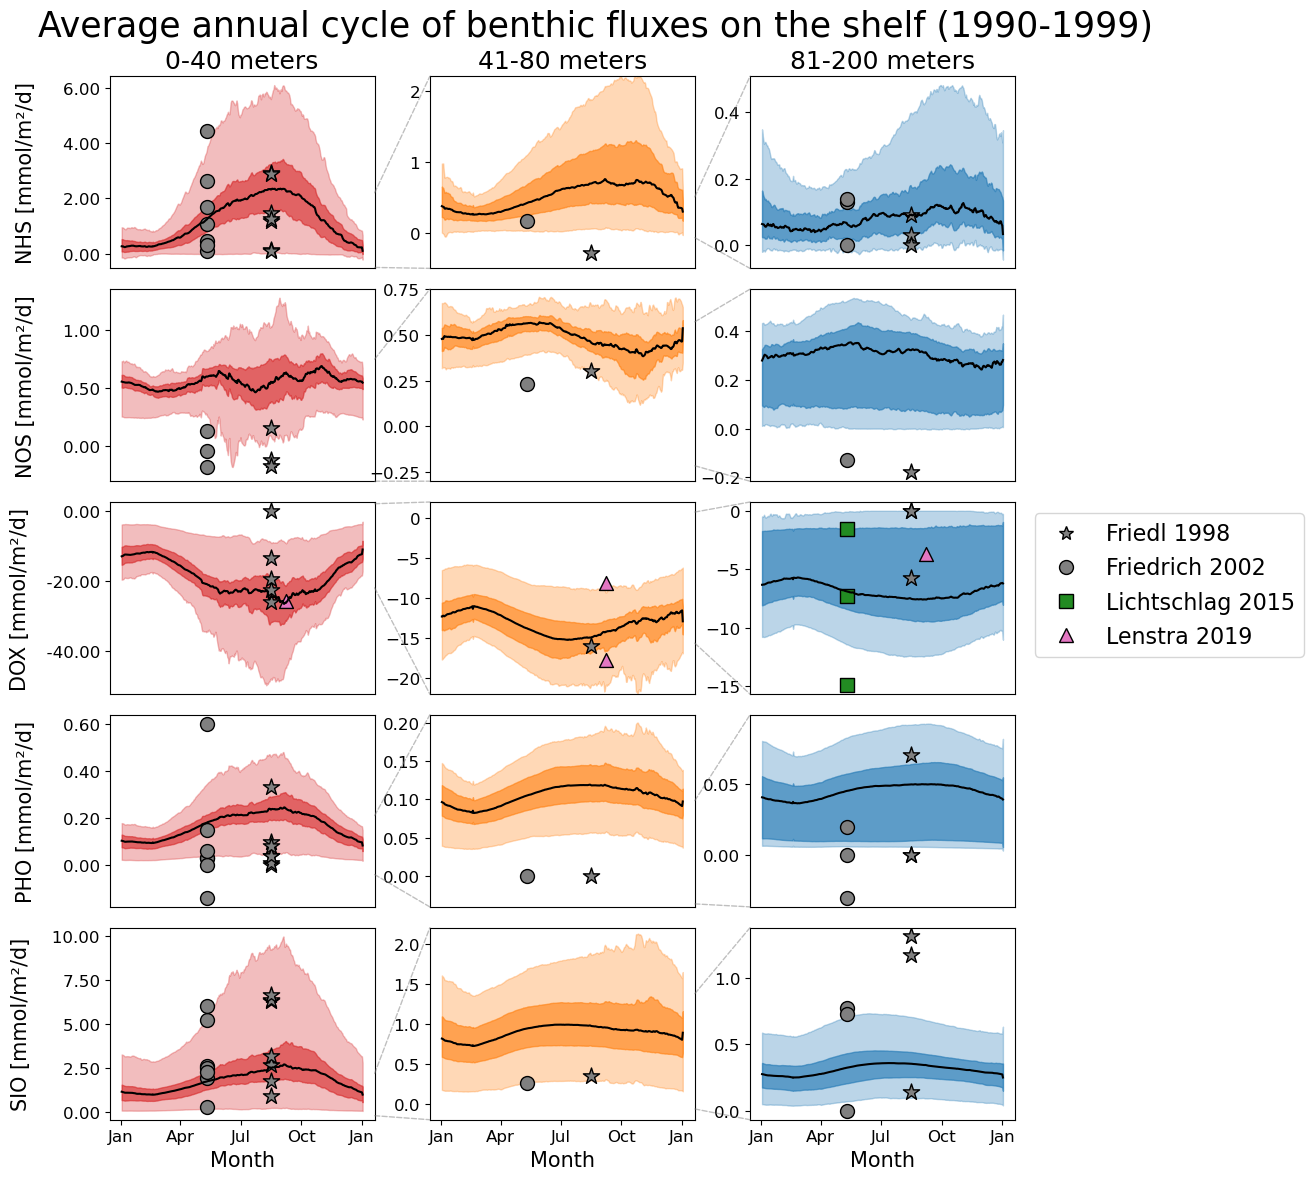

In [154]:
variabs=['botfluxNHS','botfluxNOS','botfluxDOX','botfluxPHO','botfluxSIO']

SIZE=100
AXTITLESIZE=18
LABELSIZE=15
TICKSIZE=12

#need to adjust limits by hand to get the  lines between columns right
second_col_lims=[[-0.5,2.2],[-0.3,0.75],[-22,2],[-0.04,0.21],[-0.2,2.2]]

fig, ax = plt.subplots(ncols=3, nrows=len(variabs), figsize=(12, 12))  # Increased figure width
fig.suptitle('Average annual cycle of benthic fluxes on the shelf (1990-1999)', fontsize=25)
colors=['tab:red','tab:orange','tab:blue']
pos={0:[],1:[],2:[]}
pos2={0:[],1:[],2:[]} #lenstra depth positions

lenstra_vars=['botfluxDOX']

import matplotlib.ticker as ticker

def fixed_width_formatter(x, pos):
    """Format the label to a fixed width."""
    return f"{x:8.2f}"  # 8 characters wide, 2 decimal places


# Create a list to store legend handles
legend_handles = []

#first plot medians (with waves, no waves)
for i,v in enumerate(variabs):
    for j in range(3):
        mask=masks[j]
        avg=xr.where(mask==1,avg_tot[v]*24*3600,np.nan)
        
        #median black thick line
        median=avg.median(dim=('lat','lon'))
        median.plot(ax=ax[i,j],color='black')
        perc_025 = avg.quantile(0.025, dim=('lat', 'lon'))
        perc_975 = avg.quantile(0.975, dim=('lat', 'lon'))
        ax[i, j].fill_between(median.day_of_year,perc_025, perc_975, color=colors[j], alpha=0.3)
        perc_25 = avg.quantile(0.25, dim=('lat', 'lon'))
        perc_75 = avg.quantile(0.75, dim=('lat', 'lon'))
        
        ax[i, j].fill_between(median.day_of_year,perc_25, perc_75, color=colors[j], alpha=0.6)
        #FRIEDRICH/FRIEDL
        for k,ds in friedl_da.items():
            #exclude outlier from bay of varna, see comment above.
            if (k!='Bay of Varna BS 95-13') or (v!='botfluxDOX'):

                val=mask.sel(lat=ds.lat,lon=ds.lon,method='nearest')
                jjj=0
                if val==1:
                    if (i==0):
                        pos[j].append(ds)
                    for ii,s in enumerate(ds.season):
                        datapoint=ds.sel(season=s)[v].values
                        if ii==0:
                            friedrich = ax[i,j].scatter(130,datapoint,marker='o',edgecolors='black',facecolors='gray',s=SIZE)
                        else:
                            friedli = ax[i,j].scatter(227,datapoint,marker='*',facecolors='gray',edgecolors='black',s=150)

        for k,ds in lenstra_da.items():
            if v in lenstra_vars:
                val=mask.sel(lat=ds.lat,lon=ds.lon,method='nearest')
                if val==1:
                    if (i==0):
                        pos2[j].append(ds)
                    lens=ax[i,j].scatter(250,ds[v].values.item(),marker='^',facecolors='tab:pink',s=SIZE, edgecolors='black')

        # Add Lichtschlag data (only for oxygen flux)
        if v == 'botfluxDOX':
            for lat, lon, value in lichtschlag_data:
                val = mask.sel(lat=lat, lon=lon, method='nearest')
                if val == 1:
                    licht = ax[i,j].scatter(130, value, marker='s', facecolors='forestgreen', edgecolors='black',s=SIZE)

        if i==0:
            ax[i,j].set_title(['0-40 meters','41-80 meters','81-200 meters'][j],fontsize=AXTITLESIZE)
        else:
             ax[i,j].set_title('')
        if j==0:
            ax[i,j].set_ylabel(f"{v[-3:]} [mmol/m²/d]",fontsize=LABELSIZE)
            ax[i,j].yaxis.set_major_formatter(ticker.FuncFormatter(fixed_width_formatter))
        else:
            ax[i,j].set_ylabel('',fontsize=TICKSIZE)
        if i!=(len(variabs)-1):
            ax[i,j].set_xlabel('',fontsize=TICKSIZE)
            ax[i,j].set_xticklabels([])
            ax[i, j].tick_params(axis='x', which='both', length=0)     
        else:    
            ax[i,j].set_xlabel('Month',fontsize=LABELSIZE)
            ax[i,j].xaxis.set_major_locator(months)
            ax[i,j].xaxis.set_major_formatter(month_fmt)
        if j==1:
            ax[i,j].set_ylim(second_col_lims[i])
        
        ax[i,j].tick_params(axis='both', labelsize=TICKSIZE)
        if i==1 and j==0:
             ax[i,j].set_ylim(-0.3,None)
        
        if j>0:
            aaa=ax[i, j-1]
            add_connection_patch(aaa, ax[i, j],ax[i, j].get_ylim()[0], ax[i, j].get_ylim()[0])
            add_connection_patch(aaa, ax[i, j],ax[i, j].get_ylim()[-1], ax[i, j].get_ylim()[-1])

# Update the legend handles
legend_handles = [
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markeredgecolor='black', markersize=10, label='Friedl 1998'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markeredgecolor='black', markersize=10, label='Friedrich 2002'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='forestgreen', markeredgecolor='black', markersize=10, label='Lichtschlag 2015'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='tab:pink', markeredgecolor='black', markersize=10, label='Lenstra 2019'),

]

# Add a legend to the right of the subplots
fig.legend(handles=legend_handles, 
           #labels=['Friedrich', 'Friedl', 'Lenstra', 'Lichtschlag'],
           loc='center right', bbox_to_anchor=(1.1, 0.5), fontsize=16)


plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Adjust the right margin to make space for the legend

In [155]:
fig.savefig('benthic_flux.pdf',format='pdf',bbox_inches='tight')
fig.savefig('benthic_flux.png',format='png',bbox_inches='tight')

## Optimize legend placement

Text(1.08, 1.54, 'Average annual cycle of benthic fluxes \n on the shelf (1990-1999)')

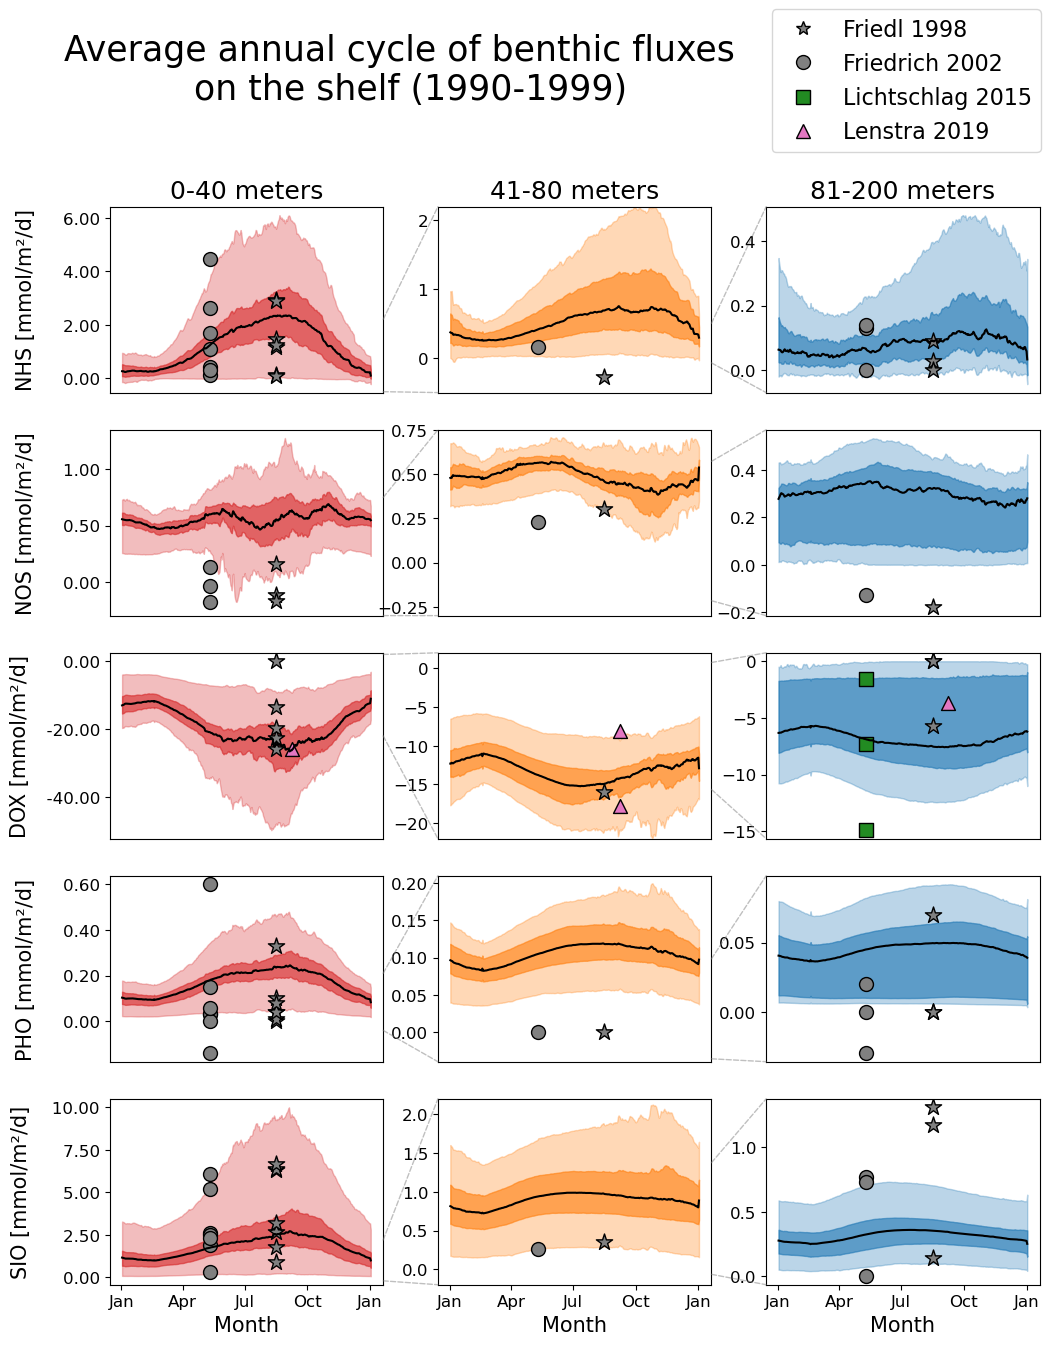

In [14]:
variabs=['botfluxNHS','botfluxNOS','botfluxDOX','botfluxPHO','botfluxSIO']

SIZE=100
AXTITLESIZE=18
LABELSIZE=15
TICKSIZE=12

#need to adjust limits by hand to get the  lines between columns right
second_col_lims=[[-0.5,2.2],[-0.3,0.75],[-22,2],[-0.04,0.21],[-0.2,2.2]]

fig, ax = plt.subplots(ncols=3, nrows=len(variabs), figsize=(12, 14))  # Increased figure width

colors=['tab:red','tab:orange','tab:blue']
pos={0:[],1:[],2:[]}
pos2={0:[],1:[],2:[]} #lenstra depth positions

lenstra_vars=['botfluxDOX']

import matplotlib.ticker as ticker

def fixed_width_formatter(x, pos):
    """Format the label to a fixed width."""
    return f"{x:8.2f}"  # 8 characters wide, 2 decimal places


# Create a list to store legend handles
legend_handles = []

#first plot medians (with waves, no waves)
for i,v in enumerate(variabs):
    for j in range(3):
        mask=masks[j]
        avg=xr.where(mask==1,avg_tot[v]*24*3600,np.nan)
        
        #median black thick line
        median=avg.median(dim=('lat','lon'))
        median.plot(ax=ax[i,j],color='black')
        perc_025 = avg.quantile(0.025, dim=('lat', 'lon'))
        perc_975 = avg.quantile(0.975, dim=('lat', 'lon'))
        ax[i, j].fill_between(median.day_of_year,perc_025, perc_975, color=colors[j], alpha=0.3)
        perc_25 = avg.quantile(0.25, dim=('lat', 'lon'))
        perc_75 = avg.quantile(0.75, dim=('lat', 'lon'))
        
        ax[i, j].fill_between(median.day_of_year,perc_25, perc_75, color=colors[j], alpha=0.6)
        #FRIEDRICH/FRIEDL
        for k,ds in friedl_da.items():
            #exclude outlier from bay of varna, see comment above.
            if (k!='Bay of Varna BS 95-13') or (v!='botfluxDOX'):

                val=mask.sel(lat=ds.lat,lon=ds.lon,method='nearest')
                jjj=0
                if val==1:
                    if (i==0):
                        pos[j].append(ds)
                    for ii,s in enumerate(ds.season):
                        datapoint=ds.sel(season=s)[v].values
                        if ii==0:
                            friedrich = ax[i,j].scatter(130,datapoint,marker='o',edgecolors='black',facecolors='gray',s=SIZE)
                        else:
                            friedli = ax[i,j].scatter(227,datapoint,marker='*',facecolors='gray',edgecolors='black',s=150)

        for k,ds in lenstra_da.items():
            if v in lenstra_vars:
                val=mask.sel(lat=ds.lat,lon=ds.lon,method='nearest')
                if val==1:
                    if (i==0):
                        pos2[j].append(ds)
                    lens=ax[i,j].scatter(250,ds[v].values.item(),marker='^',facecolors='tab:pink',s=SIZE, edgecolors='black')

        # Add Lichtschlag data (only for oxygen flux)
        if v == 'botfluxDOX':
            for lat, lon, value in lichtschlag_data:
                val = mask.sel(lat=lat, lon=lon, method='nearest')
                if val == 1:
                    licht = ax[i,j].scatter(130, value, marker='s', facecolors='forestgreen', edgecolors='black',s=SIZE)

        if i==0:
            ax[i,j].set_title(['0-40 meters','41-80 meters','81-200 meters'][j],fontsize=AXTITLESIZE)
        else:
             ax[i,j].set_title('')
        if j==0:
            ax[i,j].set_ylabel(f"{v[-3:]} [mmol/m²/d]",fontsize=LABELSIZE)
            ax[i,j].yaxis.set_major_formatter(ticker.FuncFormatter(fixed_width_formatter))
        else:
            ax[i,j].set_ylabel('',fontsize=TICKSIZE)
        if i!=(len(variabs)-1):
            ax[i,j].set_xlabel('',fontsize=TICKSIZE)
            ax[i,j].set_xticklabels([])
            ax[i, j].tick_params(axis='x', which='both', length=0)     
        else:    
            ax[i,j].set_xlabel('Month',fontsize=LABELSIZE)
            ax[i,j].xaxis.set_major_locator(months)
            ax[i,j].xaxis.set_major_formatter(month_fmt)
        if j==1:
            ax[i,j].set_ylim(second_col_lims[i])
        
        ax[i,j].tick_params(axis='both', labelsize=TICKSIZE)
        if i==1 and j==0:
             ax[i,j].set_ylim(-0.3,None)
        
        if j>0:
            aaa=ax[i, j-1]
            add_connection_patch(aaa, ax[i, j],ax[i, j].get_ylim()[0], ax[i, j].get_ylim()[0])
            add_connection_patch(aaa, ax[i, j],ax[i, j].get_ylim()[-1], ax[i, j].get_ylim()[-1])

# Update the legend handles
legend_handles = [
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markeredgecolor='black', markersize=10, label='Friedl 1998'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markeredgecolor='black', markersize=10, label='Friedrich 2002'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='forestgreen', markeredgecolor='black', markersize=10, label='Lichtschlag 2015'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='tab:pink', markeredgecolor='black', markersize=10, label='Lenstra 2019'),

]

# Add a legend to the right of the subplots
fig.legend(handles=legend_handles, 
           #labels=['Friedrich', 'Friedl', 'Lenstra', 'Lichtschlag'],
           loc='center right', bbox_to_anchor=(0.91, 0.97), fontsize=16)


ax[0,0].text(1.08, 1.54, 'Average annual cycle of benthic fluxes \n on the shelf (1990-1999)', va='bottom', ha='center',   #bbox=dict(facecolor='none', edgecolor='black'),
        rotation_mode='anchor', fontsize=25, rotation=0,
        transform=ax[0,0].transAxes)


In [149]:
fig.savefig('benthic_flux_opt.pdf',format='pdf',bbox_inches='tight')
fig.savefig('benthic_flux_opt.png',format='png',bbox_inches='tight')

# Figure Unifying locations and fluxes

/gpfs/home/acad/ulg-mast/mchoblet/.conda/envs/env/lib/python3.11/site-packages/shapely/predicates.py:671: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)


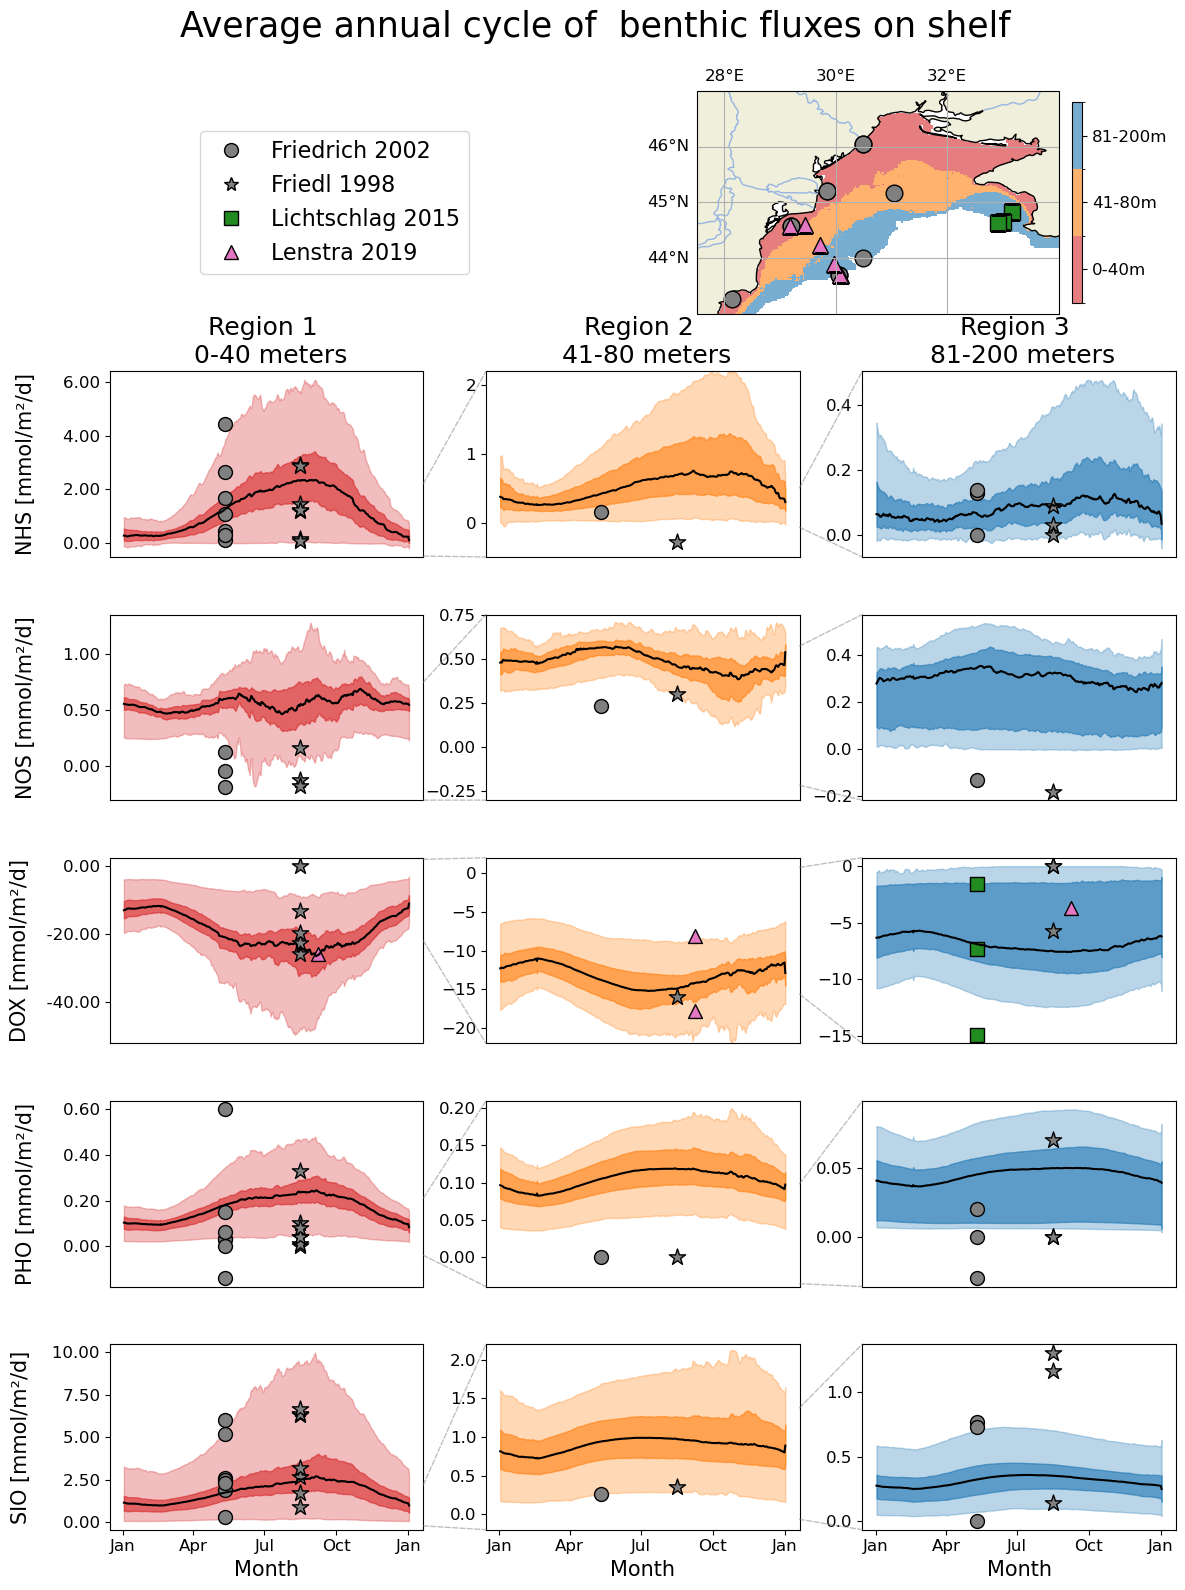

In [22]:
variabs=['botfluxNHS','botfluxNOS','botfluxDOX','botfluxPHO','botfluxSIO']

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.gridspec import GridSpec

# Constants and setup
TITLESIZE = 25
AXTITLESIZE = 18
LABELSIZE = 15
TICKSIZE = 12
LEGENDSIZE = 16
SIZE = 100

# Set up figure with GridSpec for custom layout
fig = plt.figure(figsize=(12, 16))  # Larger figure to accommodate both plots
gs = GridSpec(len(variabs) + 1, 3, height_ratios=[1.2] + [1] * len(variabs), figure=fig)

# Create the map at the top right
ax_map = fig.add_subplot(gs[0, 1:], projection=ccrs.PlateCarree())

# Your existing mask creation and map plot code
map1 = xr.where(masks[0]==1, 1, np.nan)
map2 = xr.where(masks[1]==1, 2, map1)
map3 = xr.where(masks[2]==1, 3, map2)


# Map features
ax_map.add_feature(cfeature.COASTLINE)
ax_map.add_feature(cfeature.RIVERS)
ax_map.add_feature(cfeature.LAND)

# Set extent
ax_map.set_extent([27.5, 34, 43, 47], crs=ccrs.PlateCarree())

# Gridlines
gl = ax_map.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlocator = mticker.FixedLocator([28, 30, 32, 34])
gl.ylocator = mticker.FixedLocator([44, 45, 46])
gl.xlabel_style = {'size': TICKSIZE}
gl.ylabel_style = {'size': TICKSIZE}
gl.top_labels = True
gl.bottom_labels = False
gl.right_labels = False

# Create custom colormap
colors = ['tab:red', 'tab:orange', 'tab:blue']
cmap = ListedColormap(colors)
norm = BoundaryNorm([0.5, 1.5, 2.5, 3.5], cmap.N)

# Plot the depth masks with colorbar
im = xr.where(ls_mask, map3, np.nan).plot(
    ax=ax_map,
    cmap=cmap,
    norm=norm,
    alpha=0.6,
    add_colorbar=True,
    cbar_kwargs={
        'label': None,
        'ticks': [1, 2, 3],
        'boundaries': [0.5, 1.5, 2.5, 3.5],
        'spacing': 'proportional',
        'orientation': 'vertical',
        'shrink': 0.9,
        'pad': 0.02,
    }
)

# Adjust colorbar labels after creation
im.colorbar.ax.set_yticklabels(['0-40m', '41-80m', '81-200m'], fontsize=TICKSIZE)

# Plot data points
ax_map.plot(friedl['Longitude'], friedl['Latitude'], 'o', 
        markersize=12, transform=ccrs.PlateCarree(),
        markeredgecolor='black', color='gray')

ax_map.plot([lat for lon, lat, _ in lichtschlag_data],
        [lon for lon, lat, _ in lichtschlag_data], 's',
        markersize=12, transform=ccrs.PlateCarree(),
        markeredgecolor='black', color='forestgreen')

ax_map.plot(df_lenstra['Longitude'], df_lenstra['Latitude'], '^',
        markersize=12, transform=ccrs.PlateCarree(),
        markeredgecolor='black', color='tab:pink')

# Create legend handles
legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markeredgecolor='black', markersize=10, label='Friedrich 2002'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markeredgecolor='black', markersize=10, label='Friedl 1998'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='forestgreen', markeredgecolor='black', markersize=10, label='Lichtschlag 2015'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='tab:pink', markeredgecolor='black', markersize=10, label='Lenstra 2019'),
]

# Add a single legend to the map (bottom right corner)
ax_map.legend(handles=legend_handles, 
             loc='center', 
             frameon=True,
             framealpha=0.8,bbox_to_anchor=(-1, 0.5),
             fontsize=LEGENDSIZE)

# Set map title
#ax_map.set_title("Shelf depth masks and in-situ data locations", fontsize=TITLESIZE, pad=10)
ax_map.set_title(" ", fontsize=TITLESIZE)

# Add title for the entire figure in the top left
#fig.text(0.25, 0.96, 'Average annual cycle of  benthic fluxes on shelf',          fontsize=TITLESIZE, ha='center', va='center')
fig.text(0.5, 0.98, 'Average annual cycle of  benthic fluxes on shelf', fontsize=TITLESIZE, ha='center', va='center')

# Create the time series plots
ax = []
for i, v in enumerate(variabs):
    for j in range(3):
        ax_ts = fig.add_subplot(gs[i+1, j])
        ax.append(ax_ts)
        
        mask = masks[j]
        avg = xr.where(mask==1, avg_tot[v]*24*3600, np.nan)
        
        # median black thick line
        median = avg.median(dim=('lat','lon'))
        median.plot(ax=ax_ts, color='black')
        perc_025 = avg.quantile(0.025, dim=('lat', 'lon'))
        perc_975 = avg.quantile(0.975, dim=('lat', 'lon'))
        ax_ts.fill_between(median.day_of_year, perc_025, perc_975, color=colors[j], alpha=0.3)
        perc_25 = avg.quantile(0.25, dim=('lat', 'lon'))
        perc_75 = avg.quantile(0.75, dim=('lat', 'lon'))
        
        ax_ts.fill_between(median.day_of_year, perc_25, perc_75, color=colors[j], alpha=0.6)
        
        # FRIEDRICH/FRIEDL
        for k, ds in friedl_da.items():
            # exclude outlier from bay of varna, see comment above.
            if (k != 'Bay of Varna BS 95-13') or (v != 'botfluxDOX'):
                val = mask.sel(lat=ds.lat, lon=ds.lon, method='nearest')
                if val == 1:
                    for ii, s in enumerate(ds.season):
                        datapoint = ds.sel(season=s)[v].values
                        if ii == 0:
                            ax_ts.scatter(130, datapoint, marker='o', edgecolors='black', facecolors='gray', s=SIZE)
                        else:
                            ax_ts.scatter(227, datapoint, marker='*', facecolors='gray', edgecolors='black', s=150)

        # LENSTRA
        for k, ds in lenstra_da.items():
            if v in lenstra_vars:
                val = mask.sel(lat=ds.lat, lon=ds.lon, method='nearest')
                if val == 1:
                    ax_ts.scatter(250, ds[v].values.item(), marker='^', facecolors='tab:pink', s=SIZE, edgecolors='black')

        # Add Lichtschlag data (only for oxygen flux)
        if v == 'botfluxDOX':
            for lat, lon, value in lichtschlag_data:
                val = mask.sel(lat=lat, lon=lon, method='nearest')
                if val == 1:
                    ax_ts.scatter(130, value, marker='s', facecolors='forestgreen', edgecolors='black', s=SIZE)
        
        # Set titles and labels
        if i == 0:
            ax_ts.set_title(['Region 1 \n 0-40 meters', 'Region 2 \n 41-80 meters', 'Region 3 \n 81-200 meters'][j], fontsize=AXTITLESIZE)
        else:
            ax_ts.set_title('')
        
        if j == 0:
            unit_labels = ['NH$_s$ mmol/m²/d', 'NO$_s$ mmol/m²/d', 'O$_2$ mmol/m²/d', 'PO$_s$ mmol/m²/d', 'SIO$_s$ mmol/m²/d']
            ax_ts.set_ylabel(f"{v[-3:]} [mmol/m²/d]", fontsize=LABELSIZE)
            ax_ts.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x:8.2f}"))
        else:
            ax_ts.set_ylabel('', fontsize=TICKSIZE)
        
        if i != (len(variabs) - 1):
            ax_ts.set_xlabel('', fontsize=TICKSIZE)
            ax_ts.set_xticklabels([])
            ax_ts.tick_params(axis='x', which='both', length=0)
        else:
            ax_ts.set_xlabel('Month', fontsize=LABELSIZE)
            ax_ts.xaxis.set_major_locator(months)
            ax_ts.xaxis.set_major_formatter(month_fmt)
        
        # Set y-limits for specific plots
        if j == 1:
            ax_ts.set_ylim(second_col_lims[i])
        
        if i == 1 and j == 0:
            ax_ts.set_ylim(-0.3, None)
        
        ax_ts.tick_params(axis='both', labelsize=TICKSIZE)
        
        # Add connection patches between plots
        if j > 0:
            add_connection_patch(ax[-2], ax_ts, ax_ts.get_ylim()[0], ax_ts.get_ylim()[0])
            add_connection_patch(ax[-2], ax_ts, ax_ts.get_ylim()[-1], ax_ts.get_ylim()[-1])

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.94, hspace=0.3, wspace=0.2)

/gpfs/home/acad/ulg-mast/mchoblet/.conda/envs/env/lib/python3.11/site-packages/shapely/predicates.py:671: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)


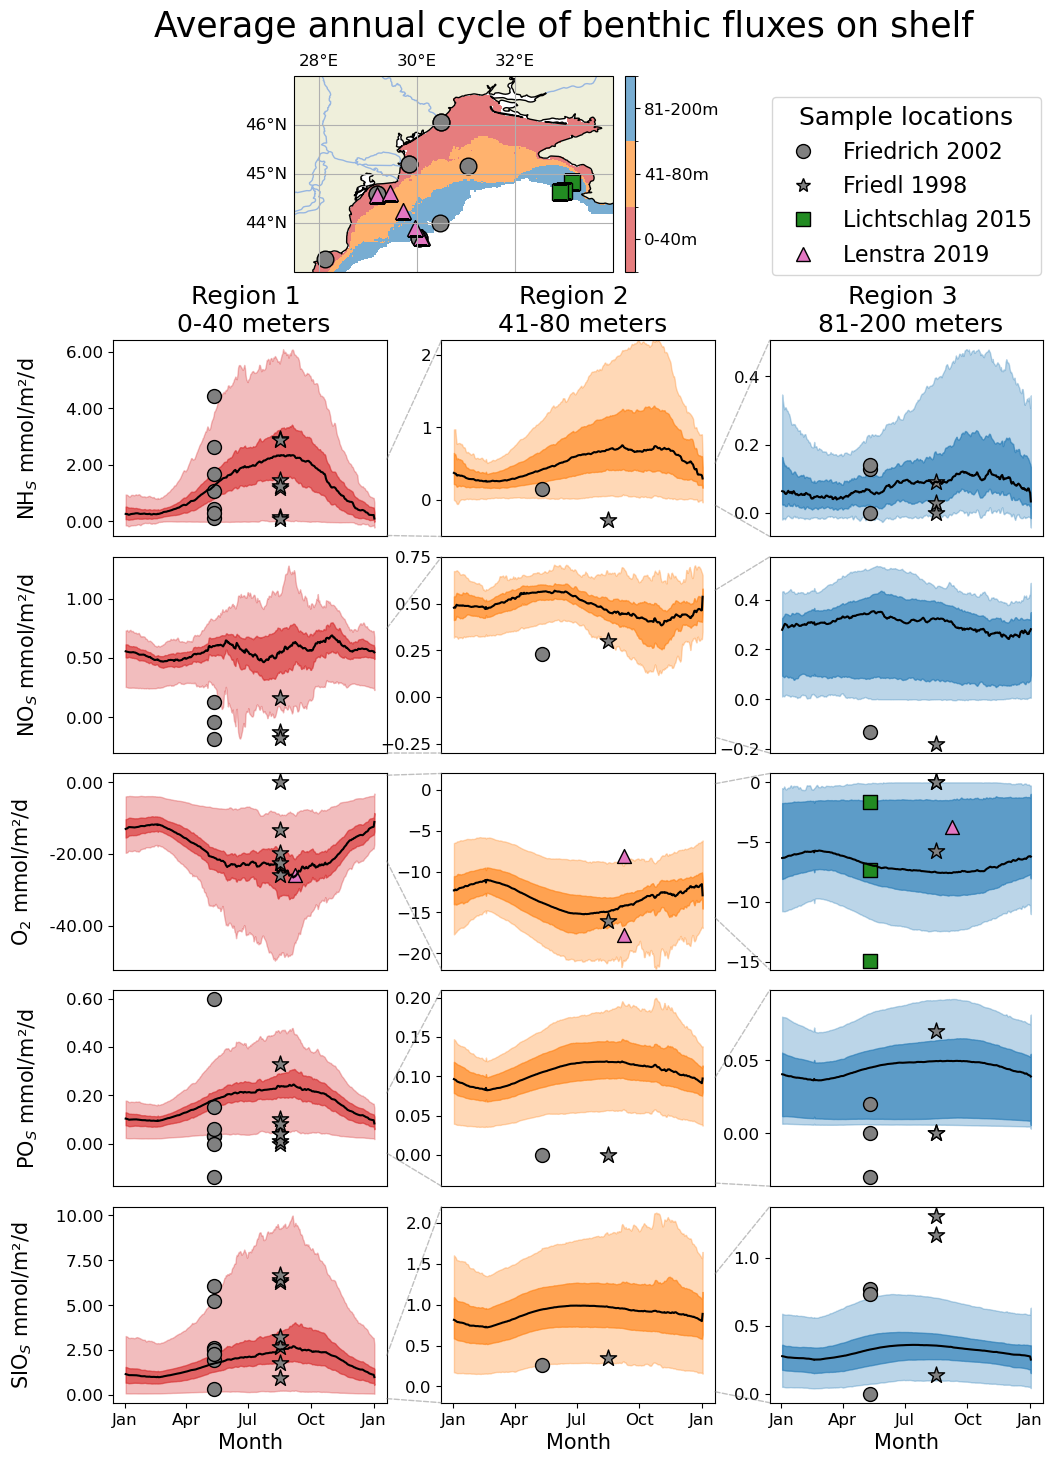

In [53]:
# Set up figure with GridSpec for custom layout
fig = plt.figure(figsize=(12, 16))  # Larger figure to accommodate both plots
gs = GridSpec(len(variabs) + 1, 3, height_ratios=[1] + [0.8] * len(variabs), figure=fig)

# Create the map at the top left (swapped positions)
ax_map = fig.add_subplot(gs[0, 0:2], projection=ccrs.PlateCarree())

# Your existing mask creation and map plot code
map1 = xr.where(masks[0]==1, 1, np.nan)
map2 = xr.where(masks[1]==1, 2, map1)
map3 = xr.where(masks[2]==1, 3, map2)

# Map features
ax_map.add_feature(cfeature.COASTLINE)
ax_map.add_feature(cfeature.RIVERS)
ax_map.add_feature(cfeature.LAND)

# Set extent
ax_map.set_extent([27.5, 34, 43, 47], crs=ccrs.PlateCarree())

# Gridlines
gl = ax_map.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlocator = mticker.FixedLocator([28, 30, 32, 34])
gl.ylocator = mticker.FixedLocator([44, 45, 46])
gl.xlabel_style = {'size': TICKSIZE}
gl.ylabel_style = {'size': TICKSIZE}
gl.top_labels = True
gl.bottom_labels = False
gl.right_labels = False

# Create custom colormap
colors = ['tab:red', 'tab:orange', 'tab:blue']
cmap = ListedColormap(colors)
norm = BoundaryNorm([0.5, 1.5, 2.5, 3.5], cmap.N)

# Plot the depth masks with colorbar
im = xr.where(ls_mask, map3, np.nan).plot(
    ax=ax_map,
    cmap=cmap,
    norm=norm,
    alpha=0.6,
    add_colorbar=True,
    cbar_kwargs={
        'label': None,
        'ticks': [1, 2, 3],
        'boundaries': [0.5, 1.5, 2.5, 3.5],
        'spacing': 'proportional',
        'orientation': 'vertical',
        'shrink': 0.9,
        'pad': 0.02,
    }
)

# Adjust colorbar labels after creation
im.colorbar.ax.set_yticklabels(['0-40m', '41-80m', '81-200m'], fontsize=TICKSIZE)

# Plot data points
ax_map.plot(friedl['Longitude'], friedl['Latitude'], 'o', 
        markersize=12, transform=ccrs.PlateCarree(),
        markeredgecolor='black', color='gray')

ax_map.plot([lat for lon, lat, _ in lichtschlag_data],
        [lon for lon, lat, _ in lichtschlag_data], 's',
        markersize=12, transform=ccrs.PlateCarree(),
        markeredgecolor='black', color='forestgreen')

ax_map.plot(df_lenstra['Longitude'], df_lenstra['Latitude'], '^',
        markersize=12, transform=ccrs.PlateCarree(),
        markeredgecolor='black', color='tab:pink')

# Create legend handles
legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markeredgecolor='black', markersize=10, label='Friedrich 2002'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markeredgecolor='black', markersize=10, label='Friedl 1998'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='forestgreen', markeredgecolor='black', markersize=10, label='Lichtschlag 2015'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='tab:pink', markeredgecolor='black', markersize=10, label='Lenstra 2019'),
]

# Add legend to the right of the map
ax_legend = fig.add_subplot(gs[0, 2])
ax_legend.axis('off')  # Hide the axis
ax_legend.legend(handles=legend_handles, 
                loc='center',
                frameon=True,
                framealpha=0.8,
                fontsize=LEGENDSIZE,title="Sample locations",title_fontsize=18)

# Set map title
ax_map.set_title(" ", fontsize=TITLESIZE)

# Add title for the entire figure
fig.text(0.5, 0.97, 'Average annual cycle of benthic fluxes on shelf', fontsize=TITLESIZE, ha='center', va='center')

# Create the time series plots
ax = []
for i, v in enumerate(variabs):
    for j in range(3):
        ax_ts = fig.add_subplot(gs[i+1, j])
        ax.append(ax_ts)
        
        mask = masks[j]
        avg = xr.where(mask==1, avg_tot[v]*24*3600, np.nan)
        
        # median black thick line
        median = avg.median(dim=('lat','lon'))
        median.plot(ax=ax_ts, color='black')
        perc_025 = avg.quantile(0.025, dim=('lat', 'lon'))
        perc_975 = avg.quantile(0.975, dim=('lat', 'lon'))
        ax_ts.fill_between(median.day_of_year, perc_025, perc_975, color=colors[j], alpha=0.3)
        perc_25 = avg.quantile(0.25, dim=('lat', 'lon'))
        perc_75 = avg.quantile(0.75, dim=('lat', 'lon'))
        
        ax_ts.fill_between(median.day_of_year, perc_25, perc_75, color=colors[j], alpha=0.6)
        
        # FRIEDRICH/FRIEDL
        for k, ds in friedl_da.items():
            # exclude outlier from bay of varna, see comment above.
            if (k != 'Bay of Varna BS 95-13') or (v != 'botfluxDOX'):
                val = mask.sel(lat=ds.lat, lon=ds.lon, method='nearest')
                if val == 1:
                    for ii, s in enumerate(ds.season):
                        datapoint = ds.sel(season=s)[v].values
                        if ii == 0:
                            ax_ts.scatter(130, datapoint, marker='o', edgecolors='black', facecolors='gray', s=SIZE)
                        else:
                            ax_ts.scatter(227, datapoint, marker='*', facecolors='gray', edgecolors='black', s=150)

        # LENSTRA
        for k, ds in lenstra_da.items():
            if v in lenstra_vars:
                val = mask.sel(lat=ds.lat, lon=ds.lon, method='nearest')
                if val == 1:
                    ax_ts.scatter(250, ds[v].values.item(), marker='^', facecolors='tab:pink', s=SIZE, edgecolors='black')

        # Add Lichtschlag data (only for oxygen flux)
        if v == 'botfluxDOX':
            for lat, lon, value in lichtschlag_data:
                val = mask.sel(lat=lat, lon=lon, method='nearest')
                if val == 1:
                    ax_ts.scatter(130, value, marker='s', facecolors='forestgreen', edgecolors='black', s=SIZE)
        
        # Set titles and labels
        if i == 0:
            ax_ts.set_title(['Region 1 \n 0-40 meters', 'Region 2 \n 41-80 meters', 'Region 3 \n 81-200 meters'][j], fontsize=AXTITLESIZE)
        else:
            ax_ts.set_title('')
        
        if j == 0:
            unit_labels = ['NH$_S$ mmol/m²/d', 'NO$_S$ mmol/m²/d', 'O$_2$ mmol/m²/d', 'PO$_S$ mmol/m²/d', 'SIO$_S$ mmol/m²/d']
            ax_ts.set_ylabel(unit_labels[i], fontsize=LABELSIZE)
            ax_ts.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x:8.2f}"))
        else:
            ax_ts.set_ylabel('', fontsize=TICKSIZE)
        
        if i != (len(variabs) - 1):
            ax_ts.set_xlabel('', fontsize=TICKSIZE)
            ax_ts.set_xticklabels([])
            ax_ts.tick_params(axis='x', which='both', length=0)
        else:
            ax_ts.set_xlabel('Month', fontsize=LABELSIZE)
            ax_ts.xaxis.set_major_locator(months)
            ax_ts.xaxis.set_major_formatter(month_fmt)
        
        # Set y-limits for specific plots
        if j == 1:
            ax_ts.set_ylim(second_col_lims[i])
        
        if i == 1 and j == 0:
            ax_ts.set_ylim(-0.3, None)
        
        ax_ts.tick_params(axis='both', labelsize=TICKSIZE)
        
        # Add connection patches between plots
        if j > 0:
            add_connection_patch(ax[-2], ax_ts, ax_ts.get_ylim()[0], ax_ts.get_ylim()[0])
            add_connection_patch(ax[-2], ax_ts, ax_ts.get_ylim()[-1], ax_ts.get_ylim()[-1])

# Adjust layout
#plt.tight_layout()
# Shrink the map and move it up

# Increase spacing between map and plots below
plt.subplots_adjust(top=0.94, hspace=0.1, wspace=0.2)


# Get current positions
map_box = ax_map.get_position()
cbar_box = im.colorbar.ax.get_position()

# Shrink the map and move it up
ax_map.set_position([map_box.x0, 
                    map_box.y0 + 0.03,  # Move up
                    map_box.width,
                    map_box.height * 0.8])  # Shrink height

# Move the colorbar to match the map
im.colorbar.ax.set_position([cbar_box.x0, 
                            map_box.y0 + 0.03,  # Match map's y0
                            cbar_box.width,
                            map_box.height * 0.8])  # Match map's height

# Get legend position
legend_box = ax_legend.get_position()

# Move legend up to match the map's new position
ax_legend.set_position([legend_box.x0, 
                        map_box.y0 + 0.03,  # Same y position as map
                        legend_box.width,
                        map_box.height * 0.7])  # Same height as map

fig.savefig('benthic_flux_loc.pdf',format='pdf',bbox_inches='tight')
fig.savefig('benthic_flux_loc.png',format='png',bbox_inches='tight')

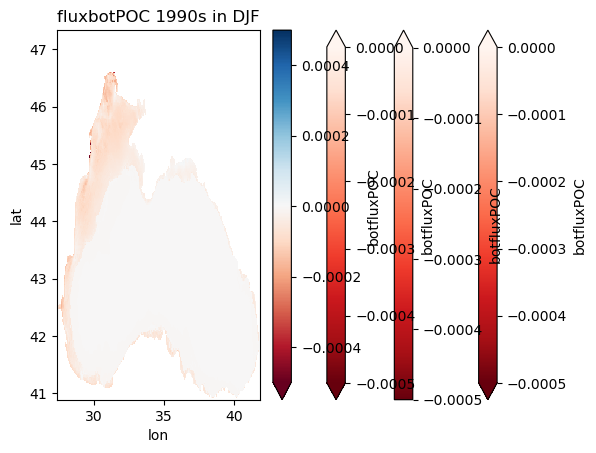

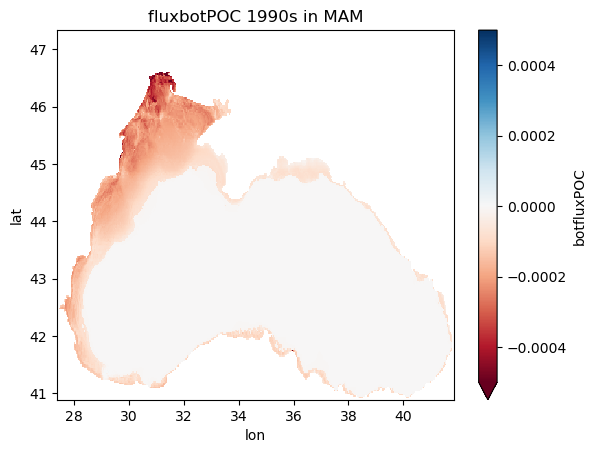

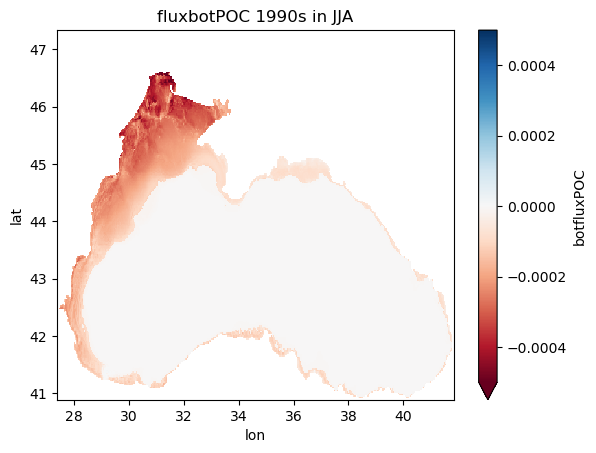

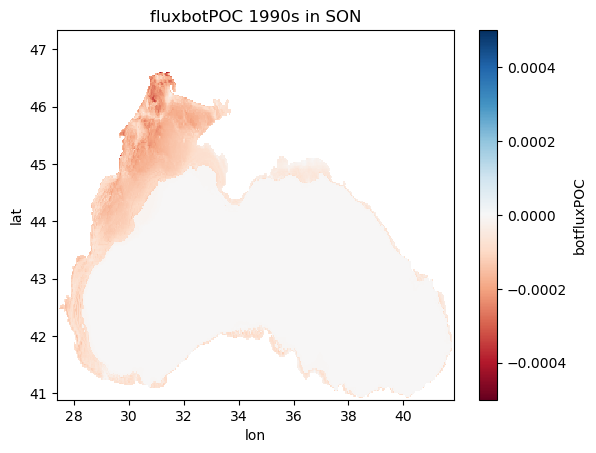

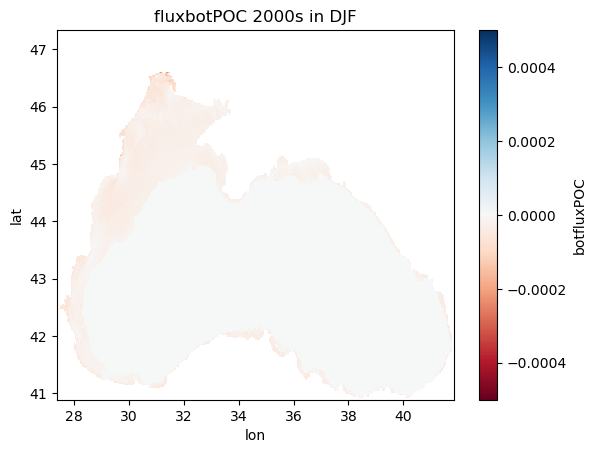

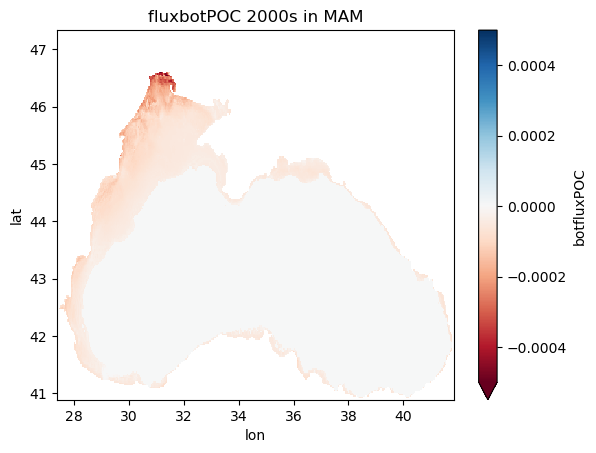

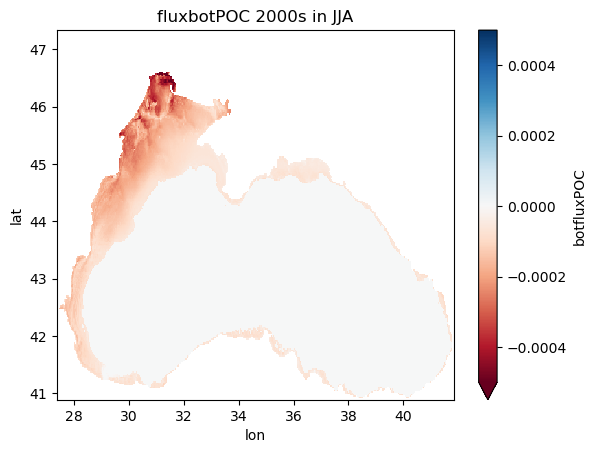

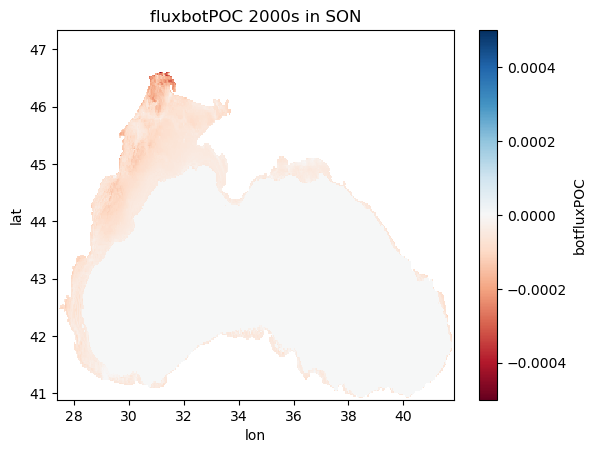

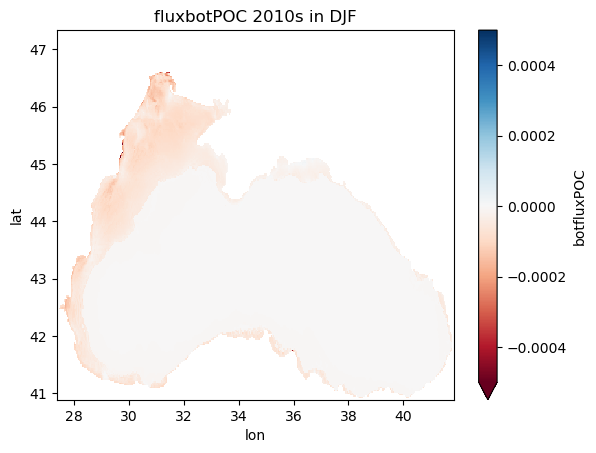

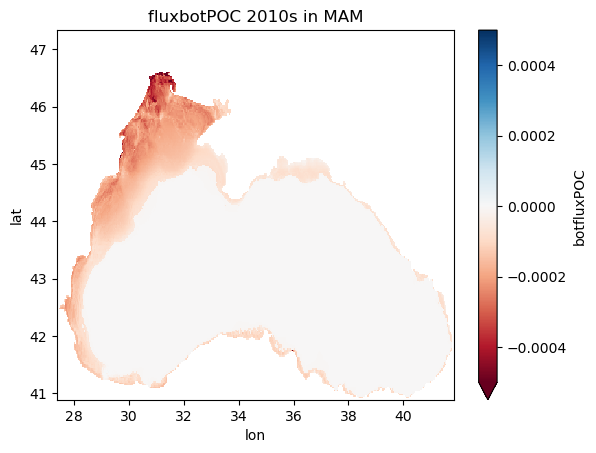

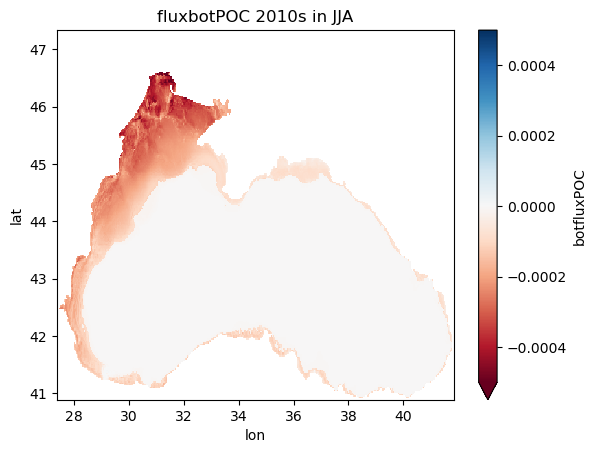

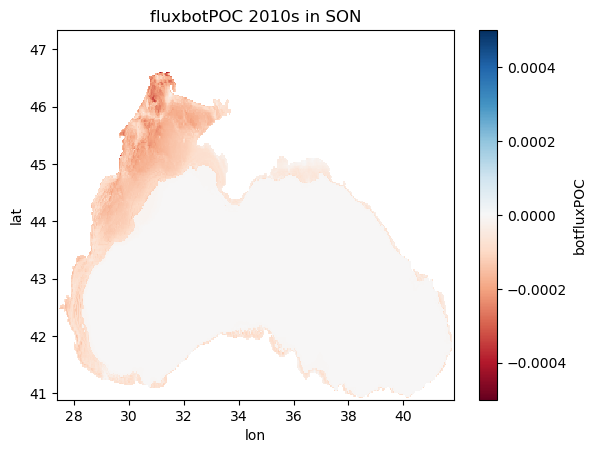

CPU times: user 29min 27s, sys: 1min, total: 30min 28s
Wall time: 1h 8min 10s


In [1]:
%%time

import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt


#Helper for nicer latitude/longitude format
def convert_xy(ds,domain_path):    
    """  
    Convert latitudes and longitudes from nested to normal + perform land sea masking
    Input:
        ds: xarray dataset (any shape)
        domain_path: path to domain file
    Output:
        ds: Dataset with simple 1D coordinates for latitudes and longitudes.
    """ 
    
    domain=xr.open_dataset(domain_path)
    lon=domain['nav_lon'][0,:].values
    lat=domain['nav_lat'][:,0].values
    
    ds=ds.rename({'y':'lat','x':'lon'})
    #assignment of new coordinates
    ds['lat']=('lat',lat)
    ds['lon']=('lon',lon)
    ds=ds.drop(('nav_lat','nav_lon'))

    #only keep at least 2 dimension variables
    ds = ds.drop_vars([var for var in ds.data_vars if ds[var].ndim < 2])
    
    #land sea masking, for this, we use top_level variable (strictly speaking, the follwing only does the masking for the first layer)
    lsmask=domain['top_level'].squeeze().rename({'y':'lat','x':'lon'})
    lsmask['lat']=lat
    lsmask['lon']=lon

    ds=xr.where(lsmask==1,ds,np.nan)
    return ds

#files with missing time axis that need to be filled
datatype='btrc_T'
missing = [ 
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/1999/BS_1d_19990217_19990217_{datatype}_19990217-19990217.nc', #will be filled with forward filling
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/1999/BS_1d_19990217_19990217_{datatype}_19990217-19990217.nc',
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/2000/BS_1d_20000121_20000121_{datatype}_20000121-20000121.nc4',
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/2000/BS_1d_20000602_20000602_{datatype}_20000602-20000602.nc4',
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/2001/BS_1d_20010802_20010802_{datatype}_20010802-20010802.nc4',
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/2003/BS_1d_20030616_20030616_{datatype}_20030616-20030616.nc4',
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/2004/BS_1d_20041124_20041124_{datatype}_20041124-20041124.nc4',
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/2006/BS_1d_20061116_20061116_{datatype}_20061116-20061116.nc4',
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/2007/BS_1d_20070407_20070407_{datatype}_20070407-20070407.nc4',
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/2007/BS_1d_20071019_20071019_{datatype}_20071019-20071019.nc4',
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/2009/BS_1d_20090418_20090418_{datatype}_20090418-20090418.nc4',
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/2010/BS_1d_20100112_20100112_{datatype}_20100112-20100112.nc4',
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/2014/BS_1d_20141004_20141004_{datatype}_20141004-20141004.nc4',
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/2015/BS_1d_20150405_20150405_{datatype}_20150405-20150405.nc4',
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/2016/BS_1d_20161225_20161225_{datatype}_20161225-20161225.nc4',
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/2017/BS_1d_20170223_20170223_{datatype}_20170223-20170223.nc4',
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/2018/BS_1d_20180915_20180915_{datatype}_20180915-20180915.nc4',
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/2020/BS_1d_20200112_20200112_{datatype}_20200112-20200112.nc4',
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/2021/BS_1d_20210714_20210714_{datatype}_20210714-20210714.nc4',
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/2021/BS_1d_20210727_20210727_{datatype}_20210727-20210727.nc4',
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/2021/BS_1d_20210829_20210829_{datatype}_20210829-20210829.nc4',
f'/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/2021/BS_1d_20210906_20210906_{datatype}_20210906-20210906.nc4',
]

#loading takes about ~10 minutes
paths=sorted(glob.glob('/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/*/BS_1d*_btrc_T*199*'))
#exclude broken files
benthic_90s=xr.open_mfdataset([p for p in paths if p not in missing])['botfluxPOC'].load().to_dataset()
#resample to have consistent time axis (missing values are nan, would need to be interpolated, or forward or backward filled)
benthic_90s_fill=benthic_90s.resample(time_counter='D').mean()
benthic_90s_fill=convert_xy(benthic_90s_fill,'/gpfs/scratch/acad/bsmfc/river_forcings/data/domain_hr.nc')

#loading takes about ~10 minutes
paths=sorted(glob.glob('/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/*/BS_1d*_btrc_T*200*'))
benthic_20s=xr.open_mfdataset([p for p in paths if p not in missing])['botfluxPOC'].load().to_dataset()
benthic_20s_fill=benthic_20s.resample(time_counter='D').mean()
benthic_20s_fill=convert_xy(benthic_20s_fill,'/gpfs/scratch/acad/bsmfc/river_forcings/data/domain_hr.nc')

#loading takes about ~10 minutes
paths=sorted(glob.glob('/gpfs/projects/acad/bsmfc/nemo4.2.0/BSFS_BIO/output_HR001/*/BS_1d*_btrc_T*201*'))
benthic_21s=xr.open_mfdataset([p for p in paths if p not in missing])['botfluxPOC'].load().to_dataset()
benthic_21s_fill=benthic_90s.resample(time_counter='D').mean()
benthic_21s_fill=convert_xy(benthic_21s_fill,'/gpfs/scratch/acad/bsmfc/river_forcings/data/domain_hr.nc')

benthic_90s_fill['botfluxPOC'].mean(('time_counter')).plot(vmax=0,cmap='Reds_r',vmin=-0.0005)
plt.title('fluxbotPOC 1990s')

benthic_20s_fill['botfluxPOC'].mean(('time_counter')).plot(vmax=0,cmap='Reds_r',vmin=-0.0005)
plt.title('fluxbotPOC 2000s')

benthic_21s_fill['botfluxPOC'].mean(('time_counter')).plot(vmax=0,cmap='Reds_r',vmin=-0.0005)
plt.title('fluxbotPOC 2010s')

for s in ['DJF','MAM','JJA','SON']:
    benthic_90s_fill['botfluxPOC'].sel(time_counter=benthic_90s_fill['botfluxPOC'].time_counter.dt.season==s).mean('time_counter').plot(cmap='RdBu',vmin=-0.0005)
    plt.title(f'fluxbotPOC 1990s in {s}')
    plt.show()

for s in ['DJF','MAM','JJA','SON']:
    benthic_20s_fill['botfluxPOC'].sel(time_counter=benthic_20s_fill['botfluxPOC'].time_counter.dt.season==s).mean('time_counter').plot(cmap='RdBu',vmin=-0.0005)
    plt.title(f'fluxbotPOC 2000s in {s}')
    plt.show()

for s in ['DJF','MAM','JJA','SON']:
    benthic_21s_fill['botfluxPOC'].sel(time_counter=benthic_21s_fill['botfluxPOC'].time_counter.dt.season==s).mean('time_counter').plot(cmap='RdBu',vmin=-0.0005)
    plt.title(f'fluxbotPOC 2010s in {s}')
    plt.show()